In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python

import io # Input/Output Module
import os # OS interfaces
import cv2 # OpenCV package
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import pickle  # import pickle, to read and save variables

from urllib import request # module for opening HTTP requests
from matplotlib import pyplot as plt # Plotting library

<div style="width:100%; height:140px">
    <img src="https://www.kuleuven.be/internationaal/thinktank/fotos-en-logos/ku-leuven-logo.png/image_preview" width = 300px, heigh = auto align=left>
</div>


KUL H02A5a Computer Vision: Group Assignment 1
---------------------------------------------------------------
Student numbers: <span style="color:red">r1, r2, r3, r4, r5</span>.

The goal of this assignment is to explore more advanced techniques for constructing features that better describe objects of interest and to perform face recognition using these features. This assignment will be delivered in groups of 5 (either composed by you or randomly assigned by your TA's).

In this assignment you are a group of computer vision experts that have been invited to ECCV 2021 to do a tutorial about  "Feature representations, then and now". To prepare the tutorial you are asked to participate in a kaggle competition and to release a notebook that can be easily studied by the tutorial participants. Your target audience is: (master) students who want to get a first hands-on introduction to the techniques that you apply.

---------------------------------------------------------------
This notebook is structured as follows:
0. Data loading & Preprocessing
1. Feature Representations
2. Evaluation Metrics 
3. Classifiers
4. Experiments
5. Publishing best results
6. Discussion

Make sure that your notebook is **self-contained** and **fully documented**. Walk us through all steps of your code. Treat your notebook as a tutorial for students who need to get a first hands-on introduction to the techniques that you apply. Provide strong arguments for the design choices that you made and what insights you got from your experiments. Make use of the *Group assignment* forum/discussion board on Toledo if you have any questions.

Fill in your student numbers above and get to it! Good luck! 


<div class="alert alert-block alert-info">
<b>NOTE:</b> This notebook is just a example/template, feel free to adjust in any way you please! Just keep things organised and document accordingly!
</div>

<div class="alert alert-block alert-info">
<b>NOTE:</b> Clearly indicate the improvements that you make!!! You can for instance use titles like: <i>3.1. Improvement: Non-linear SVM with RBF Kernel.<i>
</div>
    
---------------------------------------------------------------
# 0. Data loading & Preprocessing

## 0.1. Loading data
The training set is many times smaller than the test set and this might strike you as odd, however, this is close to a real world scenario where your system might be put through daily use! In this session we will try to do the best we can with the data that we've got! 

In [3]:
# Input data files are available in the read-only "../input/" directory

# If using kaggle:
base_file_path = "/kaggle/input/kul-h02a5a-computer-vision-ga1-2022/"
# For Thibeau: If using offline notebook:
base_file_path = "D:\Coding\MAI\CV\Group_Assignments\data"

train = pd.read_csv(
    os.path.join(base_file_path, 'train_set.csv'), index_col = 0)
train.index = train.index.rename('id')

test = pd.read_csv(
    os.path.join(base_file_path, 'test_set.csv'), index_col = 0)
test.index = test.index.rename('id')

# read the images as numpy arrays and store in "img" column
train['img'] = [cv2.cvtColor(np.load(os.path.join(base_file_path, 'train/train_{}.npy').format(index), allow_pickle=False), cv2.COLOR_BGR2RGB) 
                for index, row in train.iterrows()]

test['img'] = [cv2.cvtColor(np.load(os.path.join(base_file_path, 'test/test_{}.npy').format(index), allow_pickle=False), cv2.COLOR_BGR2RGB) 
                for index, row in test.iterrows()]
  

train_size, test_size = len(train), len(test)

"The training set contains {} examples, the test set contains {} examples.".format(train_size, test_size)

'The training set contains 80 examples, the test set contains 1816 examples.'

*Note: this dataset is a subset of the* [*VGG face dataset*](https://www.robots.ox.ac.uk/~vgg/data/vgg_face/).

## 0.2. A first look
Let's have a look at the data columns and class distribution.

In [4]:
# The training set contains an identifier, name, image information and class label
train.head(1)

name  class                                                img
id                                                                      
0   Mila_Kunis      2  [[[50, 31, 25], [49, 30, 24], [49, 30, 24], [4...

In [5]:
# The test set only contains an identifier and corresponding image information.

test.head(1)

img
id                                                   
0   [[[209, 210, 205], [208, 209, 204], [208, 209,...

In [6]:
# The class distribution in the training set:
train.groupby('name').agg({'img':'count', 'class': 'max'})

img  class
name                       
Jesse_Eisenberg   30      1
Michael_Cera      10      0
Mila_Kunis        30      2
Sarah_Hyland      10      0

Note that **Jesse is assigned the classification label 1**, and **Mila is assigned the classification label 2**. The dataset also contains 20 images of **look alikes (assigned classification label 0)** and the raw images. 

## 0.3. Preprocess data
### 0.3.1 Example: HAAR face detector
In this example we use the [HAAR feature based cascade classifiers](https://opencv-python-tutroals.readthedocs.io/en/latest/py_tutorials/py_objdetect/py_face_detection/py_face_detection.html) to detect faces, then the faces are resized so that they all have the same shape. If there are multiple faces in an image, we only take the first one. 

<div class="alert alert-block alert-info"> <b>NOTE:</b> You can write temporary files to <code>/kaggle/temp/</code> or <code>../../tmp</code>, but they won't be saved outside of the current session
</div>


In [7]:
class HAARPreprocessor():
    """Preprocessing pipeline built around HAAR feature based cascade classifiers. """
    
    def __init__(self, path, face_size):
        self.face_size = face_size
        file_path = os.path.join(path, "haarcascade_frontalface_default.xml")
        if not os.path.exists(file_path): 
            if not os.path.exists(path):
                os.mkdir(path)
            self.download_model(file_path)
        
        self.classifier = cv2.CascadeClassifier(file_path)
  
    def download_model(self, path):
        url = "https://raw.githubusercontent.com/opencv/opencv/master/data/"\
            "haarcascades/haarcascade_frontalface_default.xml"
        
        with request.urlopen(url) as r, open(path, 'wb') as f:
            f.write(r.read())
            
    def detect_faces(self, img):
        """Detect all faces in an image."""
        
        img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        return self.classifier.detectMultiScale(
            img_gray,
            scaleFactor=1.2,
            minNeighbors=5,
            minSize=(30, 30),
            flags=cv2.CASCADE_SCALE_IMAGE
        )
        
    def extract_faces(self, img):
        """Returns all faces (cropped) in an image."""
        
        faces = self.detect_faces(img)

        return [img[y:y+h, x:x+w] for (x, y, w, h) in faces]
    
    def preprocess(self, data_row):
        faces = self.extract_faces(data_row['img'])
        
        # if no faces were found, return None
        if len(faces) == 0:
            nan_img = np.empty(self.face_size + (3,))
            nan_img[:] = np.nan
            return nan_img
        
        # only return the first face
        return cv2.resize(faces[0], self.face_size, interpolation = cv2.INTER_AREA)
            
    def __call__(self, data):
        return np.stack([self.preprocess(row) for _, row in data.iterrows()]).astype(int)

**Visualise**

Let's plot a few examples.

In [8]:
# parameter to play with 
FACE_SIZE = (100, 100)

def plot_image_sequence(data, n, imgs_per_row=7):
    n_rows = 1 + int(n/(imgs_per_row+1))
    n_cols = min(imgs_per_row, n)

    f,ax = plt.subplots(n_rows,n_cols, figsize=(10*n_cols,10*n_rows))
    for i in range(n):
        if n == 1:
            ax.imshow(data[i])
        elif n_rows > 1:
            ax[int(i/imgs_per_row),int(i%imgs_per_row)].imshow(data[i])
        else:
            ax[int(i%n)].imshow(data[i])
    plt.show()

    
#preprocessed data 
preprocessor = HAARPreprocessor(path = '../../tmp', face_size=FACE_SIZE)

train_X, train_y = preprocessor(train), train['class'].values
test_X = preprocessor(test)

C:\Users\thibe\AppData\Local\Temp\ipykernel_16648\4005177570.py:53: RuntimeWarning: invalid value encountered in cast
  return np.stack([self.preprocess(row) for _, row in data.iterrows()]).astype(int)


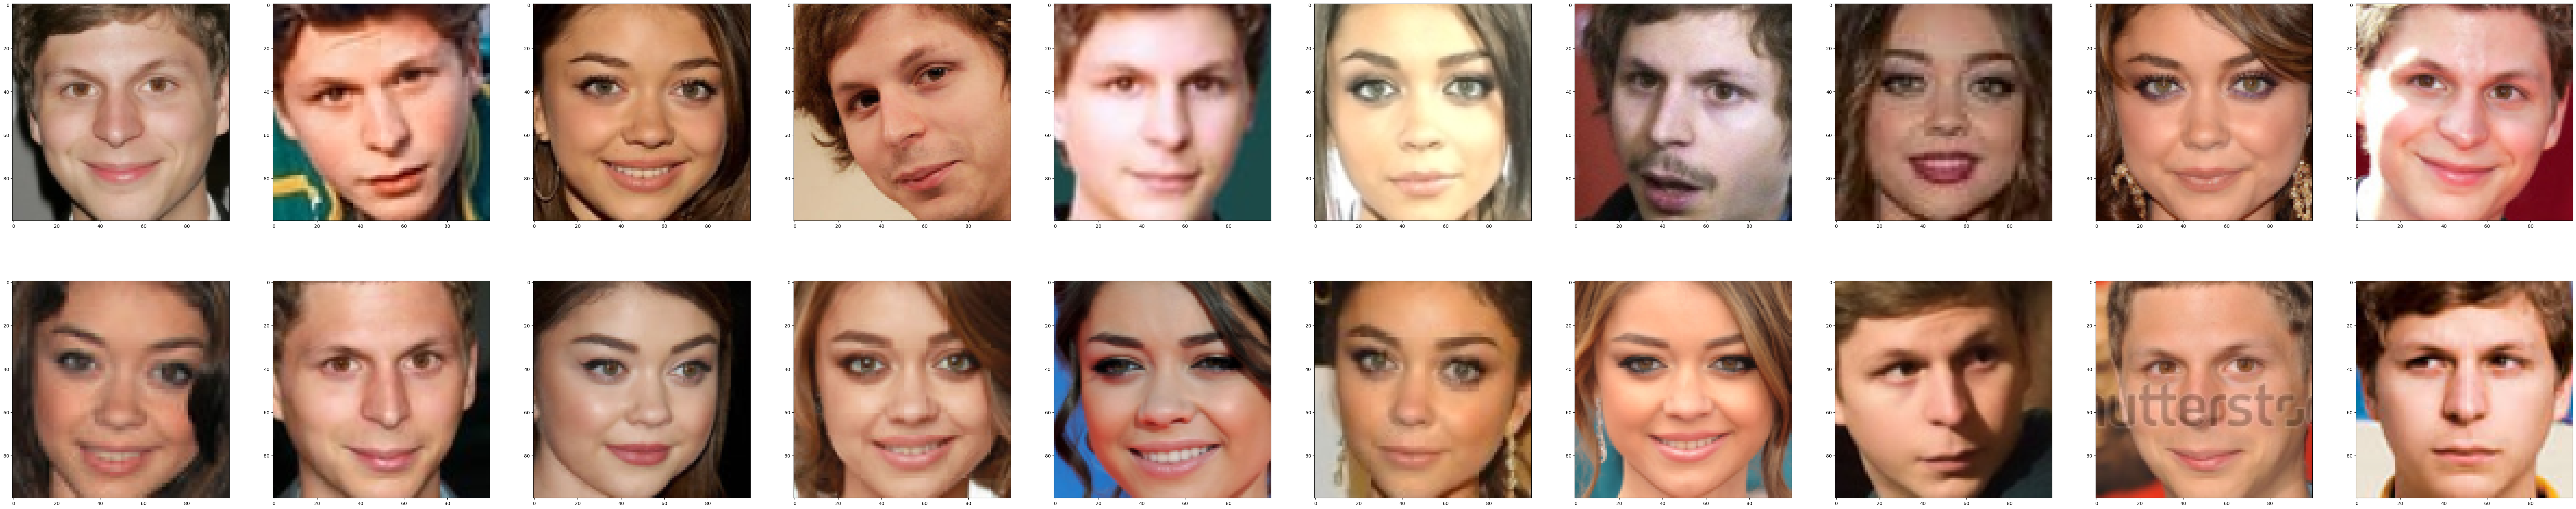

In [9]:
# plot faces of Michael and Sarah

plot_image_sequence(train_X[train_y == 0], n=20, imgs_per_row=10)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


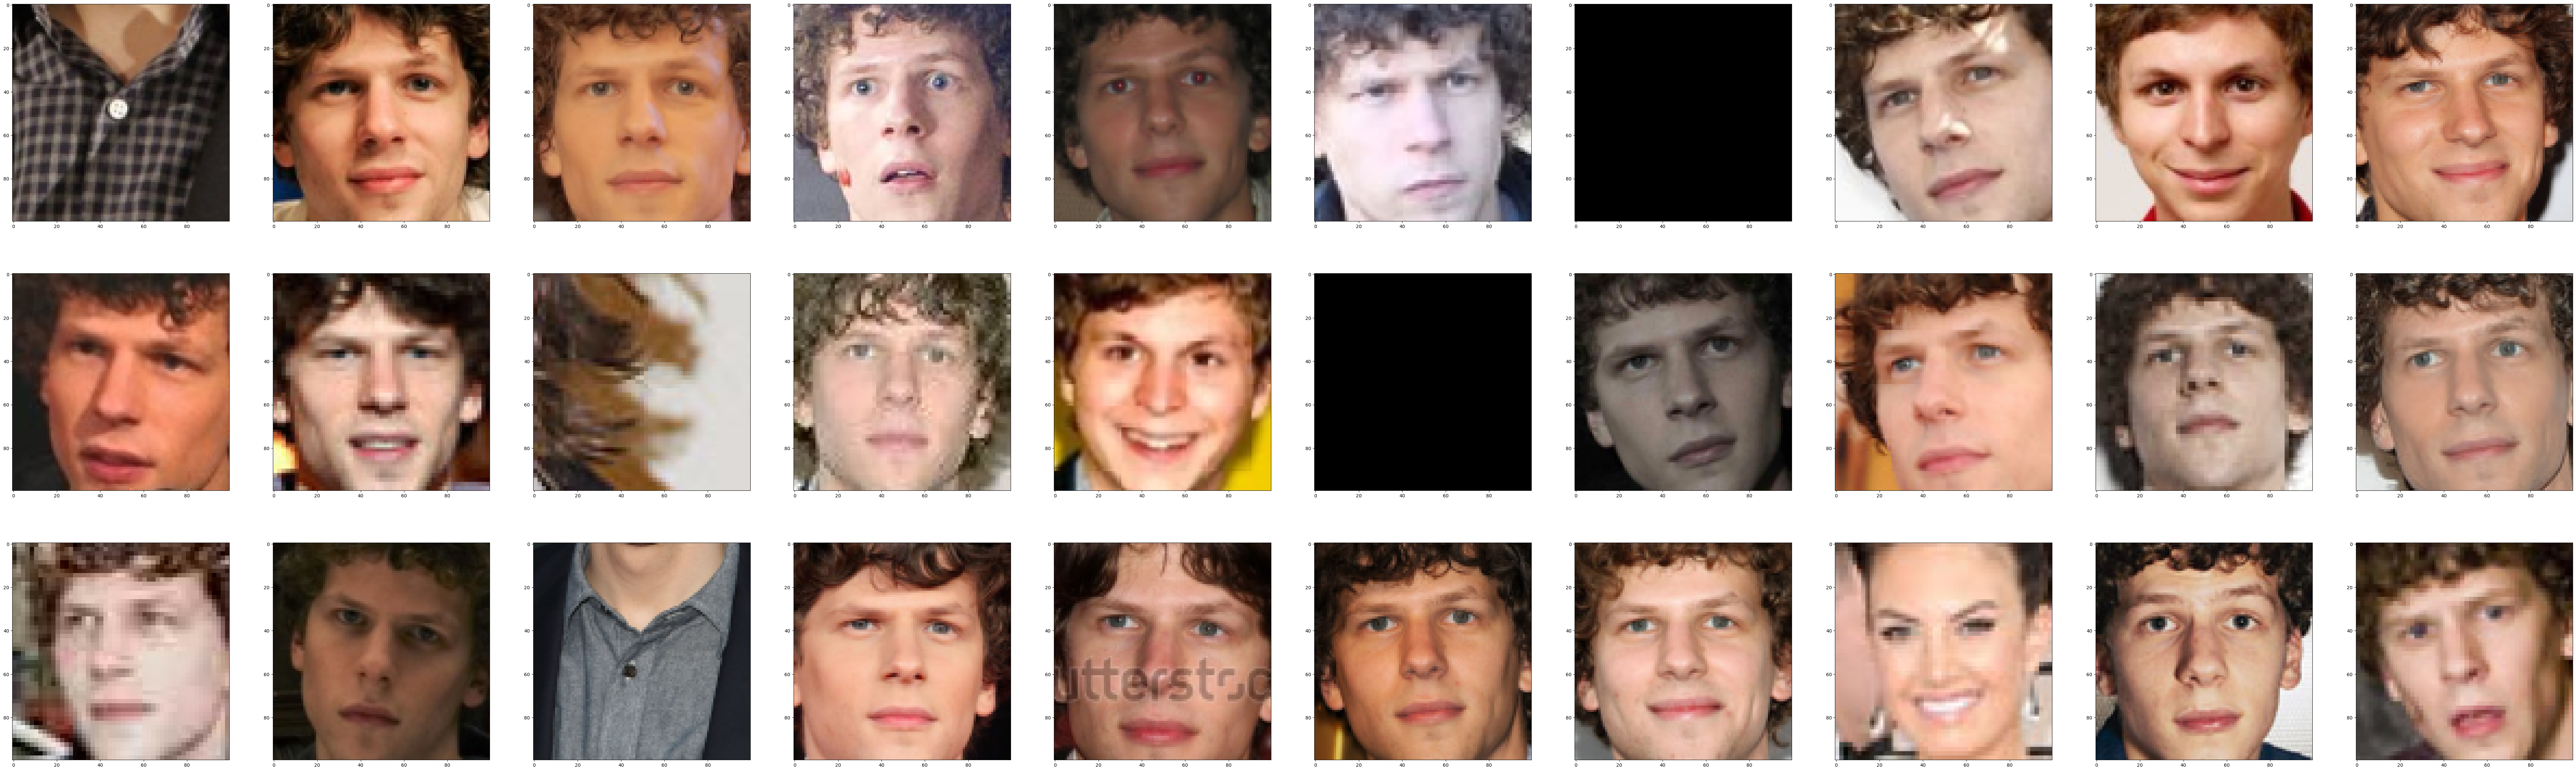

In [10]:
# plot faces of Jesse

plot_image_sequence(train_X[train_y == 1], n=30, imgs_per_row=10)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


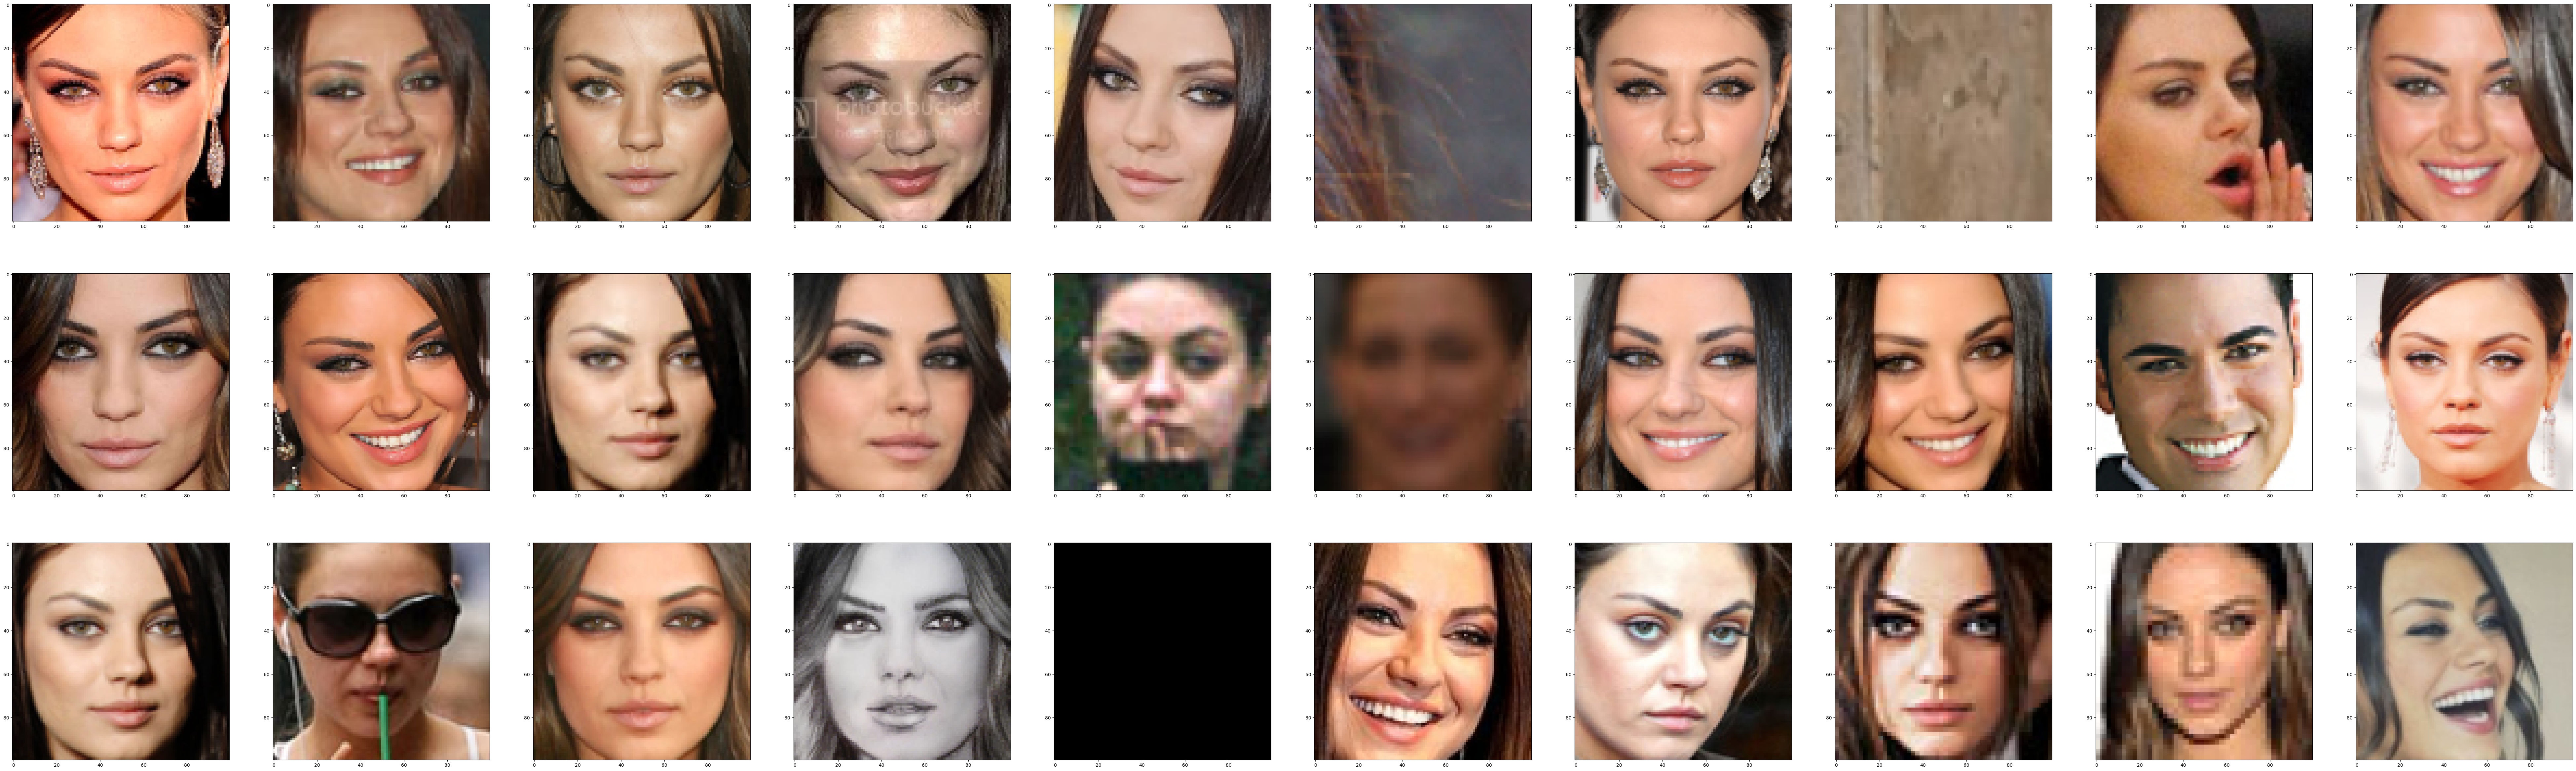

In [11]:
# plot faces of Mila

plot_image_sequence(train_X[train_y == 2], n=30, imgs_per_row=10)

Discard false positive faces from the training data

In [12]:
# Save the indices of the 
indices_to_delete = [] 

# Go over the training data, and delete images with negative pixel values
for i, img in enumerate(train_X):
    # Check if this image has any negative pixel value
    if np.any(img.flatten() < 0):
        print(f"Deleting image {i} from training data")
        indices_to_delete.append(i)
        

# Save copy with (possibly) deleted false positives again data 
train_X = np.delete(train_X, indices_to_delete, axis=0)
# remove corresponding class labels in train_y
train_y = np.delete(train_y, indices_to_delete, axis=0)

Deleting image 14 from training data
Deleting image 35 from training data
Deleting image 65 from training data


In [13]:
# remove images that aren't faces or aren't mila, jesse, michael, or sarah
# i believe there are more that should be removed
indices_not_faces = [5, 22, 23, 27, 33, 38, 48]
train_X = np.delete(train_X, indices_not_faces, axis=0)
train_y = np.delete(train_y, indices_not_faces, axis=0)

In [14]:
# NOTE - testing the above result here -- are there still false positives saved?
# Go over the training data, and delete images with negative pixel values
for i, img in enumerate(train_X):
    # Check if this image has any negative pixel value
    if np.any(img.flatten() < 0):
        print(f"WATCH OUT Image {i} does not have face -- there is a bug in the above code")

## 0.4. Store Preprocessed data (optional)
<div class="alert alert-block alert-info">
<b>NOTE:</b> You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All". Feel free to use this to store intermediary results.
</div>

In [15]:
# save preprocessed data
# prep_path = '/kaggle/working/prepped_data/'
# if not os.path.exists(prep_path):
#     os.mkdir(prep_path)
    
# np.save(os.path.join(prep_path, 'train_X.npy'), train_X)
# np.save(os.path.join(prep_path, 'train_y.npy'), train_y)
# np.save(os.path.join(prep_path, 'test_X.npy'), test_X)

# load preprocessed data
# prep_path = '/kaggle/working/prepped_data/'
# if not os.path.exists(prep_path):
#     os.mkdir(prep_path)
# train_X = np.load(os.path.join(prep_path, 'train_X.npy'))
# train_y = np.load(os.path.join(prep_path, 'train_y.npy'))
# test_X = np.load(os.path.join(prep_path, 'test_X.npy'))

Now we are ready to rock!

# 1. Feature Representations
## 1.0. Example: Identify feature extractor
Our example feature extractor doesn't actually do anything... It just returns the input:
$$
\forall x : f(x) = x.
$$

It does make for a good placeholder and baseclass ;).

In [16]:
class IdentityFeatureExtractor:
    """A simple function that returns the input"""
    
    def transform(self, X):
        return X
    
    def __call__(self, X):
        return self.transform(X)

## 1.1. Baseline 1: HOG feature extractor/Scale Invariant Feature Transform
...

In [17]:
class HOGFeatureExtractor(IdentityFeatureExtractor):
    """TODO: this feature extractor is under construction"""
    
    def __init__(**params):
        self.params = params
        
    def transform(self, X):
        raise NotImplmentedError

### 1.1.1. t-SNE Plots
...

### 1.1.2. Discussion
...

## 1.2. Baseline 2: PCA feature extractor

See *Artificial Neural Networks course, Assignment 3* for mathematical details. 

Changing gears: going back to scikit-learn

In [18]:
from sklearn.decomposition import PCA
# We use a scikit function to rescale pixel values to the (0, 255) range
from skimage.exposure import rescale_intensity

In [19]:
class PCAFeatureExtractor(IdentityFeatureExtractor):
    """
    PCA feature extractor which, given training data, finds the ideal set of principal components. Inspired by assignment 3 of the artificial neural networks course.
    """

    def __init__(self, n_components=20, use_color=True):
        """
        Initialize the PCA feature extractor.
        :param: n_components: This is either an integer, denoting the number of principal components we keep, or a float between 0 and 1, 
        indicating the amount of variance that should be explained through the PCA. 
        """

        self.n_components = n_components
        # ^ the number of principal components to be computed
        self.model = None
        # ^ the PCA model, will be initialized in fit
        self.meanface = None
        # ^ the mean of all the input training data
        self.use_color = use_color
        # ^ whether we train PCA on color images or on grayscale images


        # We will save the original shape of the input data for convenience, used inside this class
        self.width     = None
        self.height    = None
        self.shape     = None
        # self.n_samples = None

    def preprocess_data(self, X):
        # Save the original shape for later on
        # self.n_samples, self.shape = X.shape[0], X.shape[1:]
        self.shape = X.shape[1:]
        # In case we use grayscale, drop color channels
        if not self.use_color:
            self.shape = self.shape[:-1]
        self.width, self.height = self.shape[1], self.shape[2]

        if self.use_color:
            self.data_matrix = np.array([img.flatten() for img in X])
        else:
            # Convert images to grayscale
            X_gray = np.mean(X, axis=3)
            # Flatten images
            X_gray_flattened = np.reshape(X_gray, (X_gray.shape[0], (self.width, self.height)))
            self.data_matrix = X_gray_flattened

        return self.data_matrix

    def fit(self, X):
        self.model = PCA(self.n_components, svd_solver="full", whiten=True)
        self.preprocess_data(X)
        self.model.fit(self.data_matrix)
        # Also save the mean face as a 2D image, in color or grayscale
        self.meanface = rescale_intensity(self.model.mean_.reshape(self.shape), out_range=(0, 255)).astype(np.uint8)
        # Save the eigenfaces for convenience of plotting later on:
        self.eigenfaces = np.array([rescale_intensity(face.reshape(self.shape), out_range=(0, 255)).astype(np.uint8) for face in self.model.components_])

    def transform(self, X):

        # Simply call the transform of scikit-learn's PCA, but reshape the matrix in desired shape
        
        # If a single image was given, then reshape for scikit learn's PCA
        if len(X.shape) == 3:
            X = np.array([X])

        X = np.array([img.flatten() for img in X])

        return self.model.transform(X)

    def inverse_transform(self, X):

        # If a single image was given, then reshape for scikit learn's PCA
        if len(X.shape) == 3:
            X = np.array([X])

        # Go from the latent space back to original space
        reconstructed = self.model.inverse_transform(X)
        # Reshape back into a 2D image (works for both color or gray)
        reconstructed = reconstructed.reshape(self.shape)
        # Normalize the values:
        reconstructed = rescale_intensity(reconstructed, out_range=(0, 255)).astype(np.uint8)

        return reconstructed 

Initialize a new PCA object. __Note:__ if number of components is a float between 0 and 1 (such as below: 0.95), PCAFeatureExtractor will figure out the right number of components such that 95% of explained variance is kept in the components kept by PCA.

In [20]:
ncp = 20
pca = PCAFeatureExtractor(ncp)
# Fit the PCA
pca.fit(train_X)

### 1.2.1. Eigenface Plots

Before we plot below, decide which shape to use (i.e., use color channels or not)

Plot the mean face

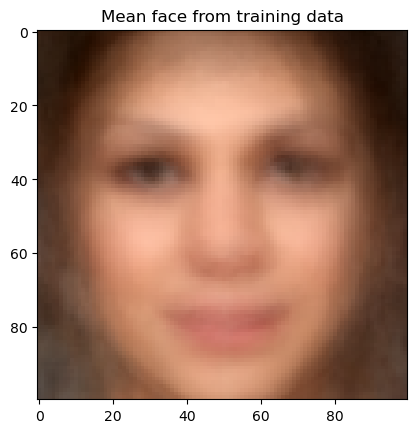

In [21]:
plt.imshow(pca.meanface, cmap="Greys_r")
plt.title("Mean face from training data")
plt.show()

Plot examples of the eigenfaces (not all shown here)

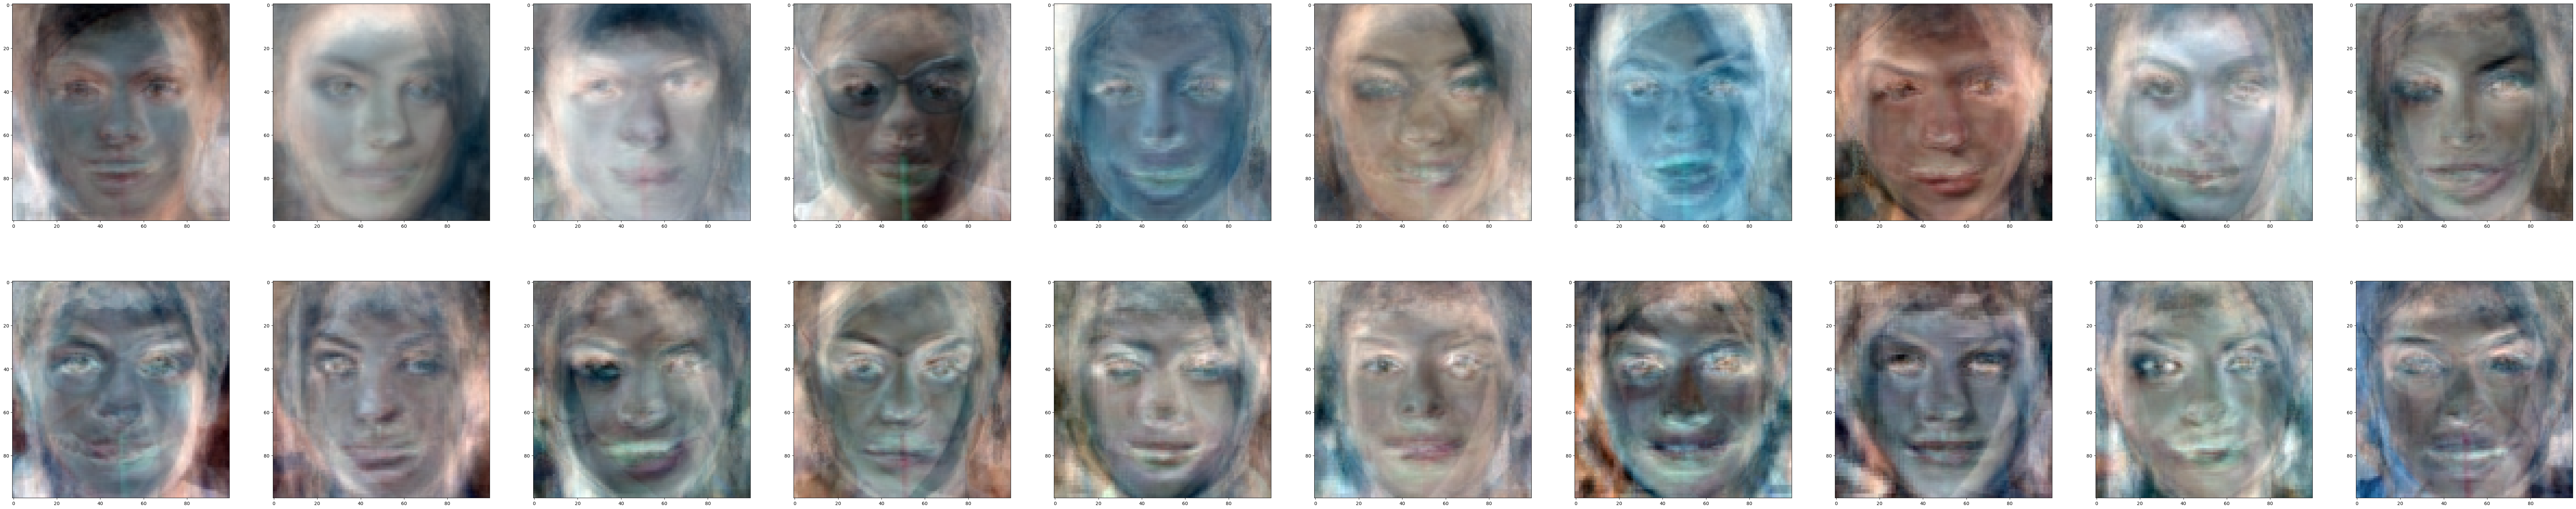

In [22]:
# Choose how many eigenfaces to plot (please, a multiple of two)
nb_eigenfaces_to_show = pca.n_components
nb_per_row = 10
plot_image_sequence(pca.eigenfaces[0:nb_eigenfaces_to_show], n=nb_eigenfaces_to_show, imgs_per_row=nb_per_row)

### 1.2.2. Feature Space Plots

We show a single reconstruction of a single test face, the third image in the train dataset.

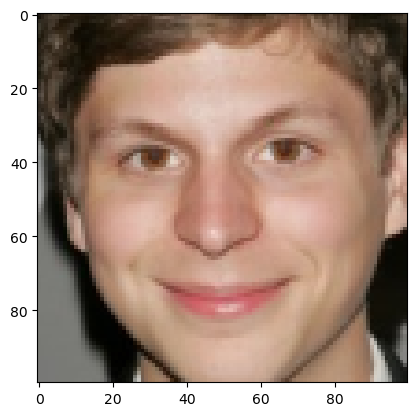

In [23]:
example_face = train_X[2]
# Show image, possibly in grayscale if desired
plt.imshow(example_face.reshape(pca.shape), cmap="Greys_r")
plt.show()

Do reconstruction (transformation & inverse transformation):

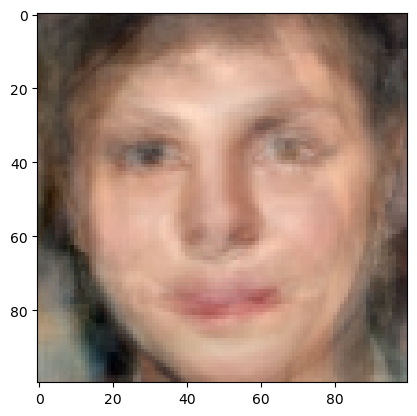

In [24]:
reduced = pca.transform(example_face)
reconstructed = pca.inverse_transform(reduced)
# Show reconstructed face:
plt.imshow(reconstructed, cmap="Greys_r")
plt.show()

Now, do this for various principal components. 

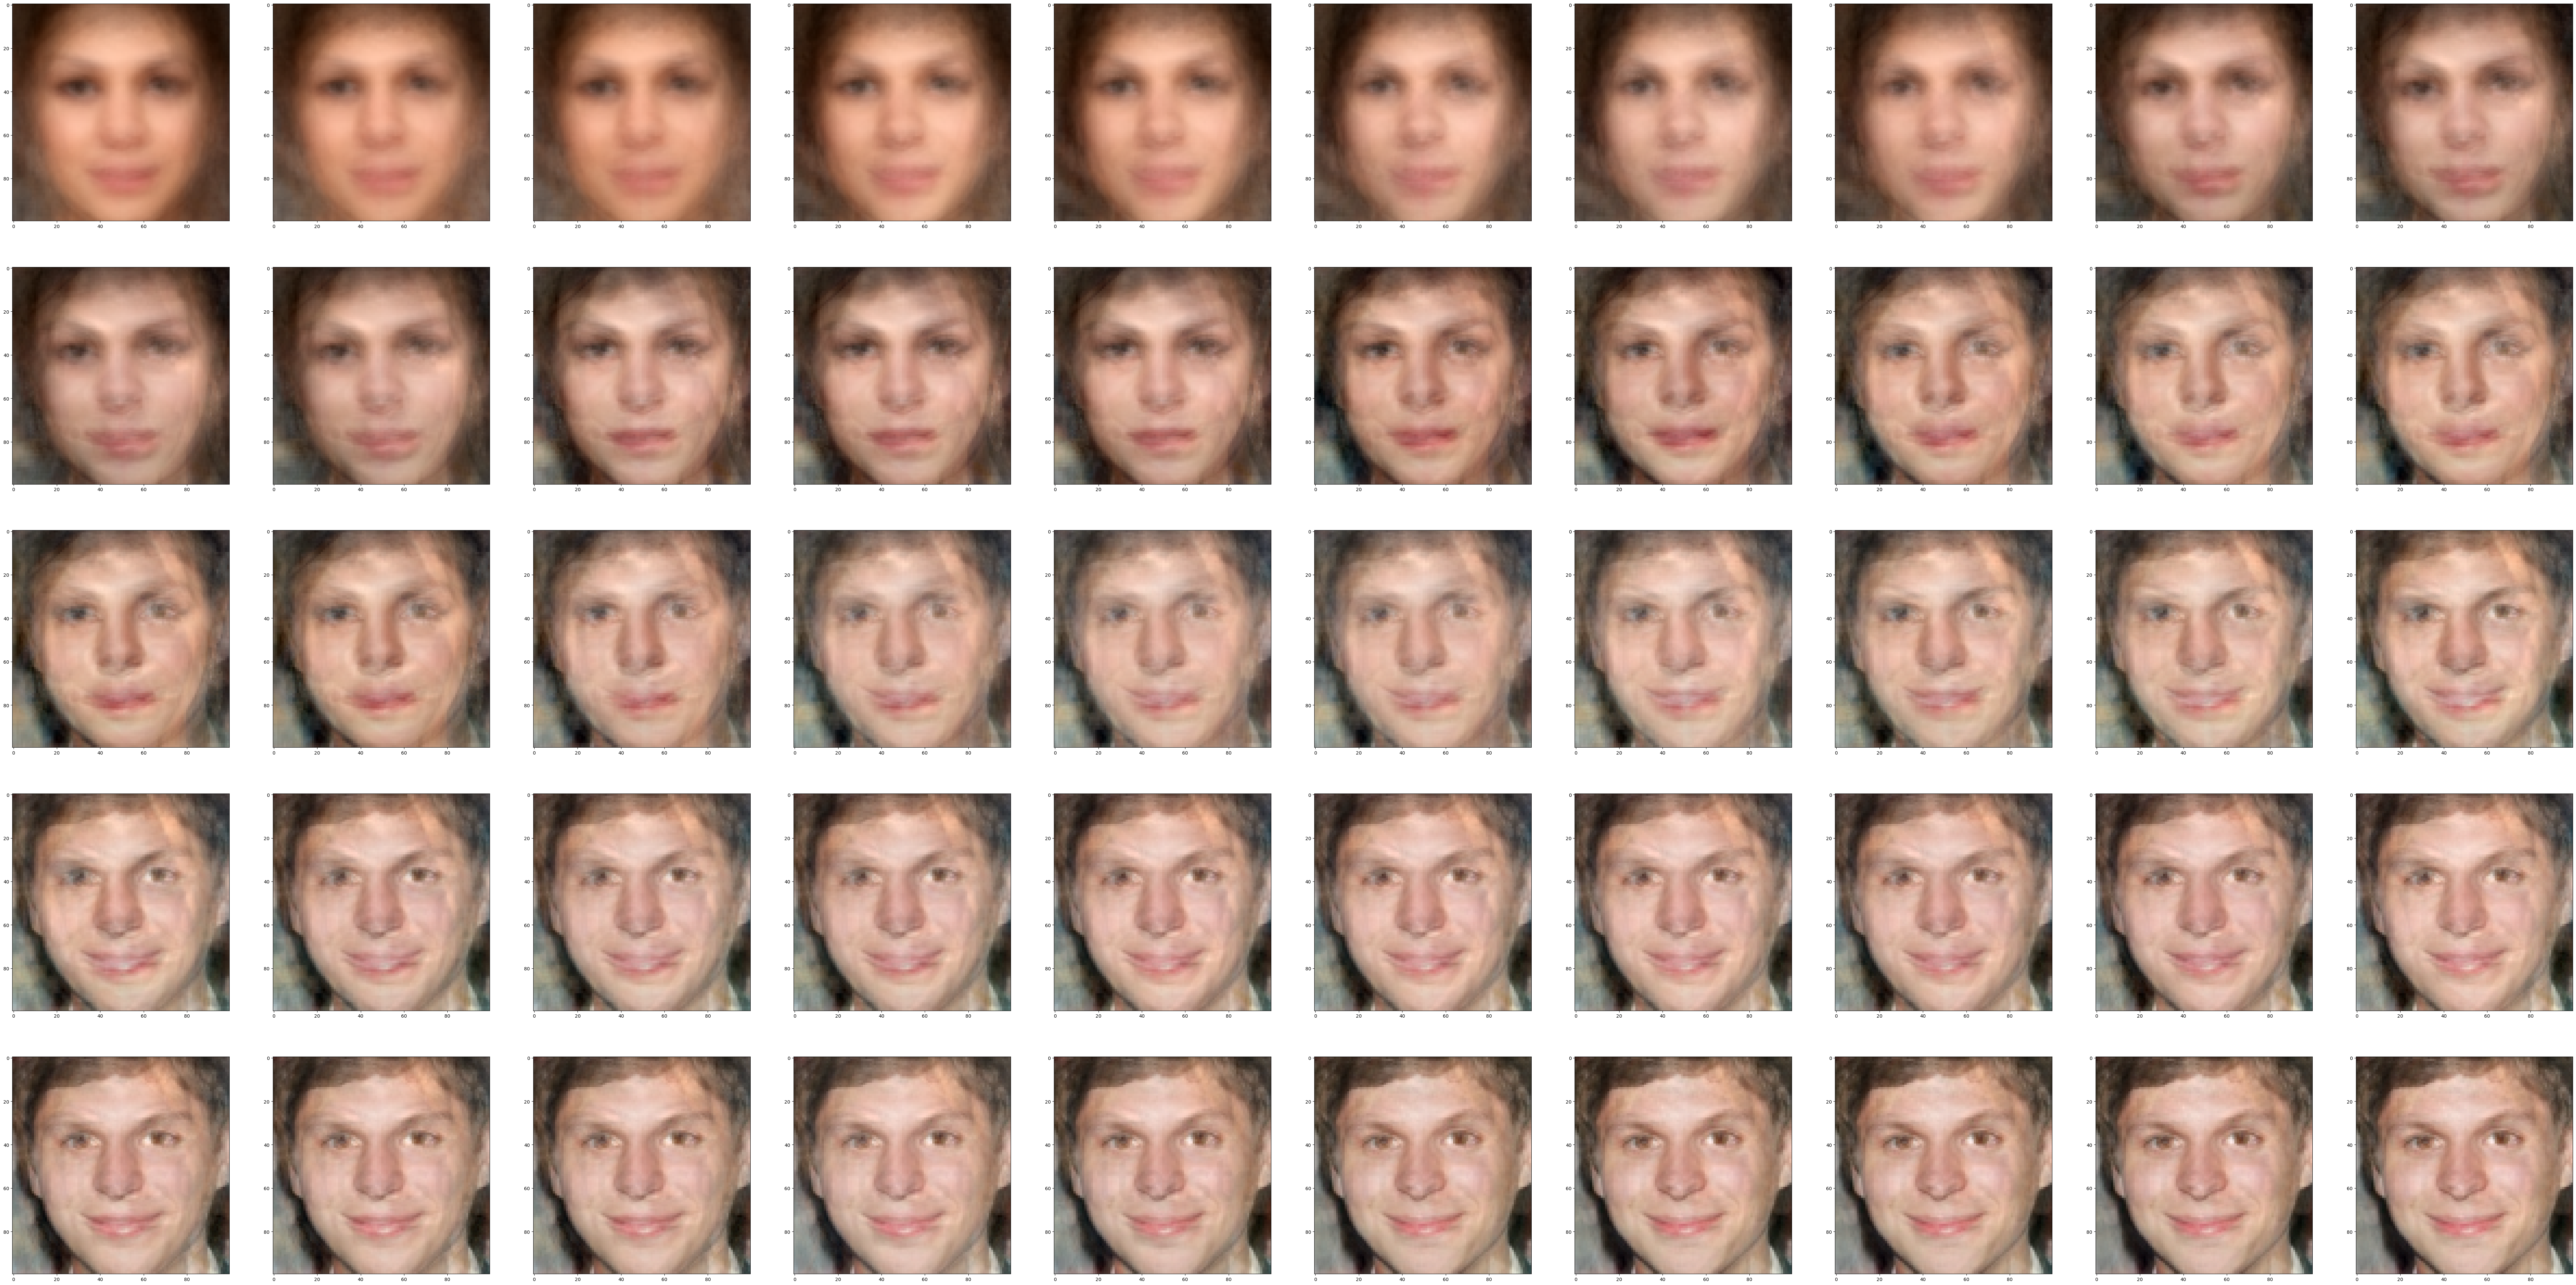

In [25]:
reconstructed_images = []
max_nb_components = 50
nb_per_row = 10

for nb_of_components in range(max_nb_components):
    # Set number of principal components and recompute the projection matrix
    pca.n_components = nb_of_components+1
    pca.fit(train_X)
    # Compute the reconstruction
    reconstructed = pca.inverse_transform(pca.transform(example_face))
    reconstructed_images.append(np.copy(reconstructed))

plot_image_sequence(reconstructed_images, n=max_nb_components, imgs_per_row=nb_per_row)

Have some way to compute error:

In [26]:
def rmsd(x, y):
    """
    Computes root mean square deviation between two arrays.
    """

    return np.sqrt(np.mean((x - y)**2))

The cell below takes around 1m30s to evaluate

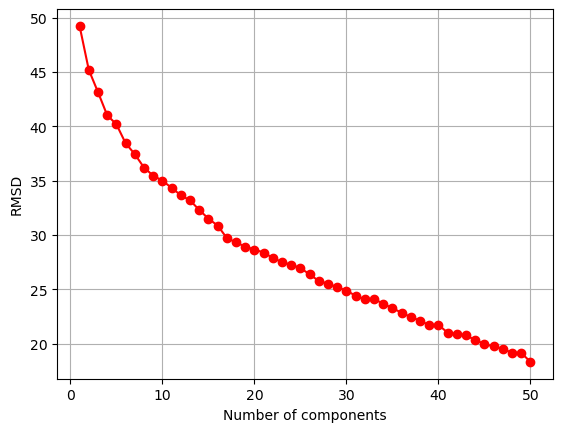

In [27]:
errors = []
max_nb_components = 50
dividing_factor = 1  # we can choose to normalize, so divide everything by 255

for i in range(max_nb_components):
    # Set number of principal components and recompute the projection matrix
    pca.n_components = i+1
    pca.fit(train_X)
    # Compute the reconstruction
    reconstructed_faces = np.array([pca.inverse_transform(pca.transform(train_face)) for train_face in train_X])
    error = np.mean([rmsd(train_X/dividing_factor, reconstructed_faces/dividing_factor)])
    # Append to list, make sure to reshap
    errors.append(error)

plt.plot([i+1 for i in range(len(errors))], errors, '-o', color='red')
plt.ylabel("RMSD")
plt.xlabel("Number of components")
plt.grid()
plt.show()

#### Face-feature plots

In [28]:
pca.n_components = 2
pca.fit(train_X)

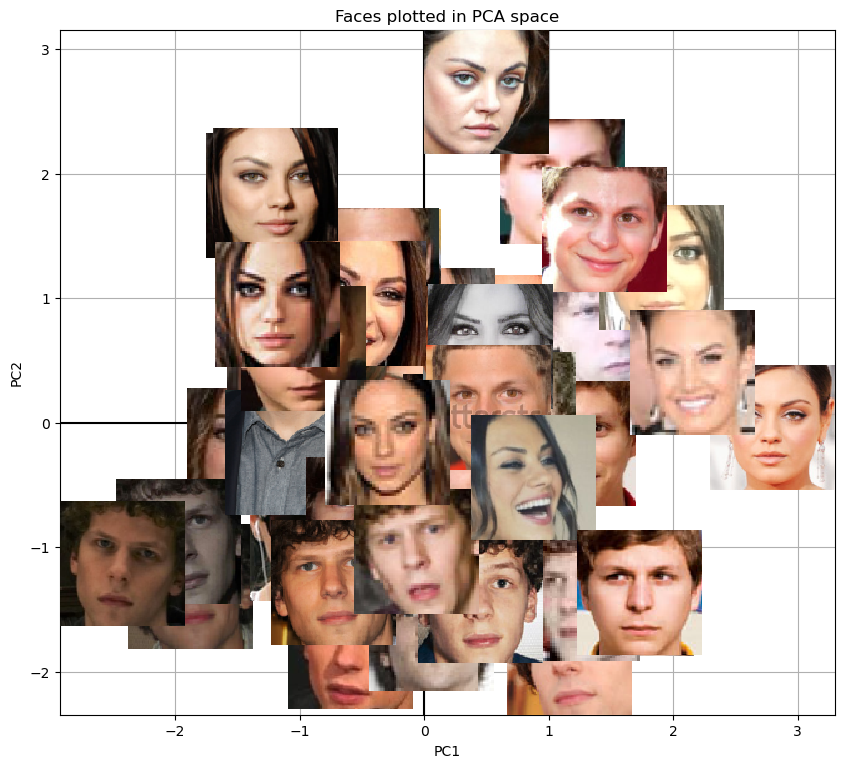

In [29]:
fig, ax = plt.subplots(figsize = (10,10))
delta_image = 0.5
delta_plot = 0.5
latent_reps = np.array([pca.transform(image).flatten() for image in train_X])  # flatten... bit awkward

for i in range(train_X.shape[0]):
    image = train_X[i]
    latent = latent_reps[i]
    ax.imshow(image, interpolation='nearest', extent=(latent[0]-delta_image, latent[0]+delta_image, latent[1]-delta_image, latent[1]+delta_image), zorder=100)
# Make image clean
plt.xlim(latent_reps[:, 0].min()-delta_plot, latent_reps[:, 0].max()+delta_plot)
plt.ylim(latent_reps[:, 1].min()-delta_plot, latent_reps[:, 1].max()+delta_plot)
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('Faces plotted in PCA space')
plt.axhline(0, color="black")
plt.axvline(0, color="black")
plt.grid()
plt.show()

Similar plots, but show the classes instead

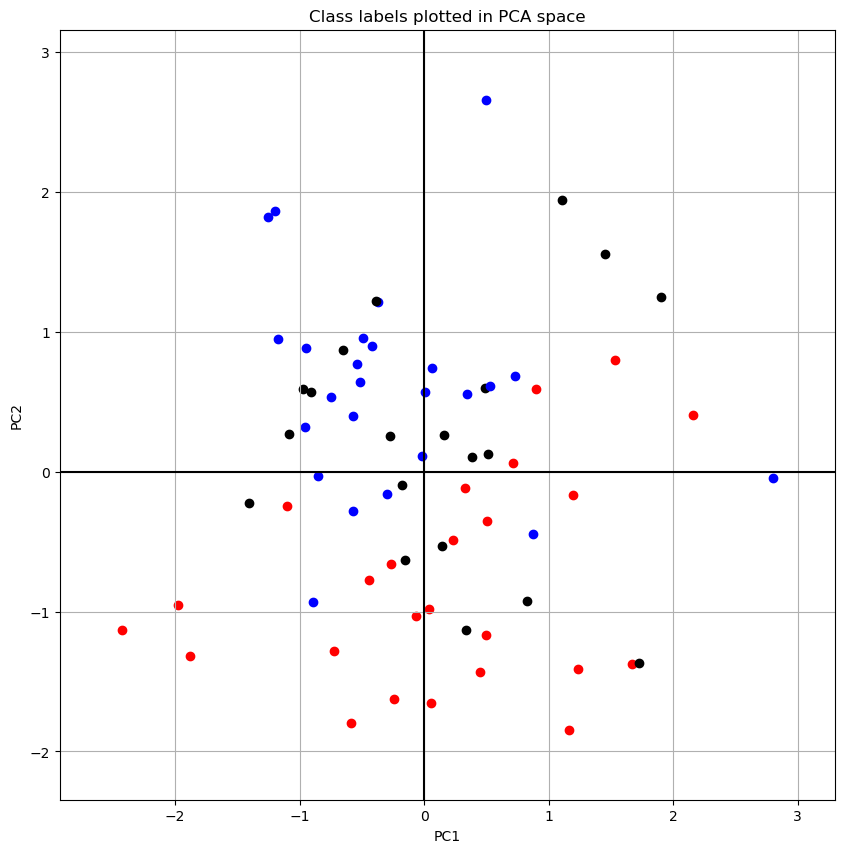

In [30]:
fig = plt.figure(figsize = (10,10))
delta_image = 0.5
delta_plot = 0.5
latent_reps = np.array([pca.transform(image).reshape((2,)) for image in train_X])

colors = ["black", "red", "blue"]

for i in range(train_X.shape[0]):
    image = train_X[i]
    latent = latent_reps[i]
    plt.scatter(latent[0], latent[1], color = colors[train_y[i]])

# Make image clean
plt.xlim(latent_reps[:, 0].min()-delta_plot, latent_reps[:, 0].max()+delta_plot)
plt.ylim(latent_reps[:, 1].min()-delta_plot, latent_reps[:, 1].max()+delta_plot)
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('Class labels plotted in PCA space')
plt.axhline(0, color="black")
plt.axvline(0, color="black")
plt.grid()
plt.show()

### 1.2.3. Discussion

TO DO...

# 2. Evaluation Metrics
## 2.0. Example: Accuracy
As example metric we take the accuracy. Informally, accuracy is the proportion of correct predictions over the total amount of predictions. It is used a lot in classification but it certainly has its disadvantages...

In [31]:
from sklearn.metrics import accuracy_score, multilabel_confusion_matrix, matthews_corrcoef, classification_report, ConfusionMatrixDisplay

# 3. Classifiers
## 3.0. Example: The *'not so smart'* classifier
This random classifier is not very complicated. It makes predictions at random, based on the distribution obseved in the training set. **It thus assumes** that the class labels of the test set will be distributed similarly to the training set.

In [32]:
class RandomClassificationModel:
    """Random classifier, draws a random sample based on class distribution observed 
    during training."""
    
    def fit(self, X, y):
        """Adjusts the class ratio instance variable to the one observed in y. 

        Parameters
        ----------
        X : tensor
            Training set
        y : array
            Training set labels

        Returns
        -------
        self : RandomClassificationModel
        """
        
        self.classes, self.class_ratio = np.unique(y, return_counts=True)
        self.class_ratio = self.class_ratio / self.class_ratio.sum()
        return self
        
    def predict(self, X):
        """Samples labels for the input data. 

        Parameters
        ----------
        X : tensor
            dataset
            
        Returns
        -------
        y_star : array
            'Predicted' labels
        """

        np.random.seed(0)
        return np.random.choice(self.classes, size = X.shape[0], p=self.class_ratio)
    
    def __call__(self, X):
        return self.predict(X)
    

## 3.1. Baseline 1: My favorite classifier

For SVM, see [this tutorial](https://scikit-learn.org/stable/auto_examples/applications/plot_face_recognition.html).

In [33]:
from sklearn.svm import SVC
from sklearn.utils.fixes import loguniform
from sklearn.model_selection import RandomizedSearchCV, train_test_split
import time

In [42]:
pca = PCAFeatureExtractor()
pca.fit(train_X)

In [43]:
# Get the PCA representation of train and test data
train_X_pca = np.array([pca.transform(face).flatten() for face in train_X])

In [44]:
# Perform train test split
X_train, X_test, y_train, y_test = train_test_split(
    train_X_pca, train_y, test_size=0.25, random_state=42
)

# Now search for best params for SVC

param_grid = {
    "C": loguniform(1e-1, 1e5),
    "gamma": loguniform(1e-7, 1e2),
}
clf = RandomizedSearchCV(
    SVC(kernel="rbf", class_weight="balanced"), param_grid, n_iter=500
)
start = time.time()
clf = clf.fit(X_train, y_train)
end = time.time()
print("done in %0.3fs" % (end - start))
print("Best estimator found by grid search:")
print(clf.best_estimator_)

done in 18.493s
Best estimator found by grid search:
SVC(C=80590.32173776685, class_weight='balanced', gamma=0.005373676766496415)


              precision    recall  f1-score   support

           0       0.67      0.40      0.50         5
           1       1.00      1.00      1.00         6
           2       0.67      0.86      0.75         7

    accuracy                           0.78        18
   macro avg       0.78      0.75      0.75        18
weighted avg       0.78      0.78      0.76        18



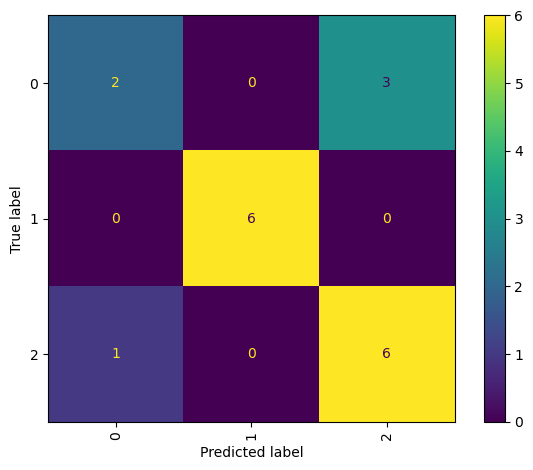

In [45]:
pred_y = clf.predict(X_test)

print(classification_report(y_test, pred_y))
ConfusionMatrixDisplay.from_estimator(
    clf, X_test, y_test, xticks_rotation="vertical"
)
plt.tight_layout()
plt.show()

In [46]:
class FavoriteClassificationModel:
    """TODO: this classifier is under construction."""

    def __init__(self):

        self.model = None

    
    def fit(self, X, y):
        # Now search for best params for SVC

        param_grid = {
            "C": loguniform(1e-1, 1e5),
            "gamma": loguniform(1e-7, 1e2),
        }
        clf = RandomizedSearchCV(
            SVC(kernel="rbf", class_weight="balanced"), param_grid, n_iter=500
        )
        clf = clf.fit(X_train, y_train)
        print(clf.best_estimator_)

        # Save the best model
        self.model = clf.best_estimator_


    def predict(self, X):
        return self.model.predict(X)
    
    def __call__(self, X):
        return self.predict(X)

# 4. Experiments
<div class="alert alert-block alert-info"> <b>NOTE:</b> Do <i>NOT</i> use this section to keep track of every little change you make in your code! Instead, highlight the most important findings and the major (best) pipelines that you've discovered.  
</div>
<br>

## 4.0. Example: basic pipeline
The basic pipeline takes any input and samples a label based on the class label distribution of the training set. As expected the performance is very poor, predicting approximately 1/4 correctly on the training set. There is a lot of room for improvement but this is left to you ;). 

__NOTE__ this is very basic and brute force code as test

In [47]:
feature_extractor = PCAFeatureExtractor()
feature_extractor.fit(train_X)
classifier = FavoriteClassificationModel()

print(np.shape(feature_extractor(train_X)))

# train the model on the features
classifier.fit(feature_extractor(train_X), train_y)

# model/final pipeline
model = lambda X: classifier(feature_extractor(X))

(70, 20)
SVC(C=6994.678179461122, class_weight='balanced', gamma=0.004930889822679738)


In [48]:
# evaluate performance of the model on the training set
train_y_star = model(train_X)

"The performance on the training set is {:.2f}. This however, does not tell us much about the actual performance (generalisability).".format(
    accuracy_score(train_y, train_y_star))

'The performance on the training set is 0.94. This however, does not tell us much about the actual performance (generalisability).'

In [49]:
# predict the labels for the test set 
test_y_star = model(test_X)

# 5. Publishing best results

In [50]:
submission = test.copy().drop('img', axis = 1)
submission['class'] = test_y_star

submission

class
id         
0         1
1         2
2         1
3         1
4         1
...     ...
1811      2
1812      0
1813      1
1814      0
1815      0

[1816 rows x 1 columns]

In [51]:
submission.to_csv('submission.csv')

# 6. Discussion
...

In summary we contributed the following: 
* 
